In [167]:
import numpy as np
import pylab as plt
from hera_sim.antpos import linear_array
from hera_filters import dspec
%matplotlib notebook

In [168]:
nfreqs = 200
nants = 20
npix = 300
freqs = np.linspace(50e6, 250e6, nfreqs)
sky = np.random.uniform(0, 10, size=(1, npix)) * (freqs[:, None] / 150e6) ** -0.75
l = np.linspace(-1, 1, npix)
beam = np.sinc(l[:, None] / np.sin(0.25 * 150e6 / freqs[None, :]))
s_hat = np.array([l])

antpos = linear_array(nants, sep=5)

bls = []
scale = 1
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            bls.append((antpos[aj] - antpos[ai]) * scale)
            
bls = np.array(bls)[:, 0][:, None]


dx = np.diff(l)[0]
u = (freqs * bls / 2.998e8)

top = np.argsort(sky[0])[2:]

fringe1 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] + dx / 2))
fringe2 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] - dx / 2))
fringe = 1./(-2j * np.pi * u[..., None]) * (fringe1 - fringe2) / dx
V_sky = np.sum(sky[None, :, :] * beam.T[None] * fringe, axis=-1)
V_sky_inc = np.sum(sky[None, :, top] * beam[top].T[None] * fringe[..., top], axis=-1)



In [169]:
ant_amp = np.random.uniform(0.5, 1.5, (len(antpos), nfreqs))
ant_phase = np.random.uniform(0, 2 * np.pi, (len(antpos), nfreqs))


In [170]:
vis_dict = {}
model_dict = {}
true_dict = {}
ci = 0
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            g1 = ant_amp[ai] * np.exp(1j * ant_phase[ai])
            g2 = ant_amp[aj] * np.exp(1j * ant_phase[aj])
            vis_dict[(ai, aj)] = V_sky[ci] * g1 * g2.conj()
            vis_dict[(aj, ai)] = vis_dict[(ai, aj)].conj()
            model_dict[(ai, aj)] = V_sky_inc[ci]
            true_dict[(ai, aj)] = V_sky[ci]
            true_dict[(aj, ai)] = true_dict[(ai, aj)].conj()
            model_dict[(aj, ai)] = model_dict[(ai, aj)].conj()
            ci += 1
            
            


In [171]:
from jax import numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

In [172]:

def create_G_stef(R, M, imax, tau):
    N = R.shape[0]
    temp =np.ones((R.shape[0],R.shape[1]) ,dtype=complex)
    G = np.zeros(R.shape,dtype=complex)
    g = np.zeros((R.shape[0],R.shape[2]),dtype=complex)
    niters = []
    for t in range(R.shape[2]):
        g_temp = np.ones((N,),dtype=complex) 
        for i in range(imax):
            g_old = np.copy(g_temp)
            for p in range(N):
                z = g_old*M[:,p,t]
                g_temp[p] = np.sum(np.conj(R[:,p,t])*z)/(np.sum(np.conj(z)*z))
            if (i%2 == 0):
                if (np.sqrt(np.sum(np.absolute(g_temp-g_old)**2))/np.sqrt(np.sum(np.absolute(g_temp)**2)) <= tau):
                    niters.append(i)
                    break
                else:
                    g_temp = (g_temp + g_old)/2       
        else:
            niters.append(imax)

        G_m = np.dot(np.diag(g_temp),temp)
        G_m = np.dot(G_m,np.diag(g_temp.conj()))           

        g[:,t] = g_temp       
        G[:,:,t] = G_m

    return g,G,niters

@jax.jit
def stefcal(data_matrix, model_matrix, wgts, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    def inner_function(args):
        """
        """
        g_temp, i, tau = args
        g_old = jnp.copy(g_temp)
        zg = g_temp[:, None] * model_matrix
        zgw = g_temp[:, None] * model_matrix * wgts
        g_temp = jnp.sum(jnp.conj(data_matrix) * zgw, axis=(0)) / jnp.sum(jnp.conj(zgw) * zg, axis=(0))
        g_temp = g_temp * stepsize + g_old * (1 - stepsize)
        tau = jnp.sqrt(jnp.sum(jnp.abs(g_temp - g_old) ** 2))/ jnp.sqrt(jnp.sum(jnp.abs(g_temp)**2))
        return g_temp, i + 1, tau
    
    def conditional_function(args):
        """
        """
        _, i, tau = args
        return (tau > tol) & (i < maxiter)
    
    nants = data_matrix.shape[0]
    gains = jnp.ones(nants, dtype=complex)
    
    return jax.lax.while_loop(conditional_function, inner_function, (gains, 0, 1))

def run_stefcal(data_matrix, model_matrix, wgts, tol=1e-10, maxiter=500, stepsize=0.5):
    """
    """
    gains = []
    niter = []
    for i in range(data_matrix.shape[-1]):
        g, i, tau = stefcal(data_matrix[..., i], model_matrix[..., i], wgts[..., i], tol=tol, maxiter=maxiter, stepsize=stepsize)
        gains.append(g)
        niter.append(i)
        
    return np.array(gains).T, np.array(niter).T

In [173]:
%%time
Nants = nants
fi = 0

data_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
true_model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)

for n in range(Nants):
    for m in range(Nants):
        if n != m:
            data_matrix[m, n] = vis_dict[(m, n)]
            model_matrix[m, n] = model_dict[(m, n)]
            true_model_matrix[m, n] = true_dict[(m, n)]
            
wgts = np.ones_like(model_matrix).real

CPU times: user 3.73 ms, sys: 4.65 ms, total: 8.38 ms
Wall time: 7.85 ms


In [174]:
%%time
gstef, niter = run_stefcal(data_matrix, model_matrix, wgts, maxiter=1000, tol=1e-10, stepsize=0.5)

CPU times: user 166 ms, sys: 111 ms, total: 276 ms
Wall time: 447 ms


In [176]:
%%time
g, G, _ = create_G_stef(data_matrix, model_matrix, 1000, 1e-10)

CPU times: user 2.04 s, sys: 11.6 ms, total: 2.05 s
Wall time: 2.06 s


In [177]:
Gf = gstef[:, None, :] * gstef[None, ...].conj()

In [179]:
cal = data_matrix / G
cal_f = data_matrix / Gf

In [180]:
import uvtools
def delay_spectra(x):
    """
    """
    return np.abs(uvtools.utils.FFT(x, taper='bh7'))

<IPython.core.display.Javascript object>


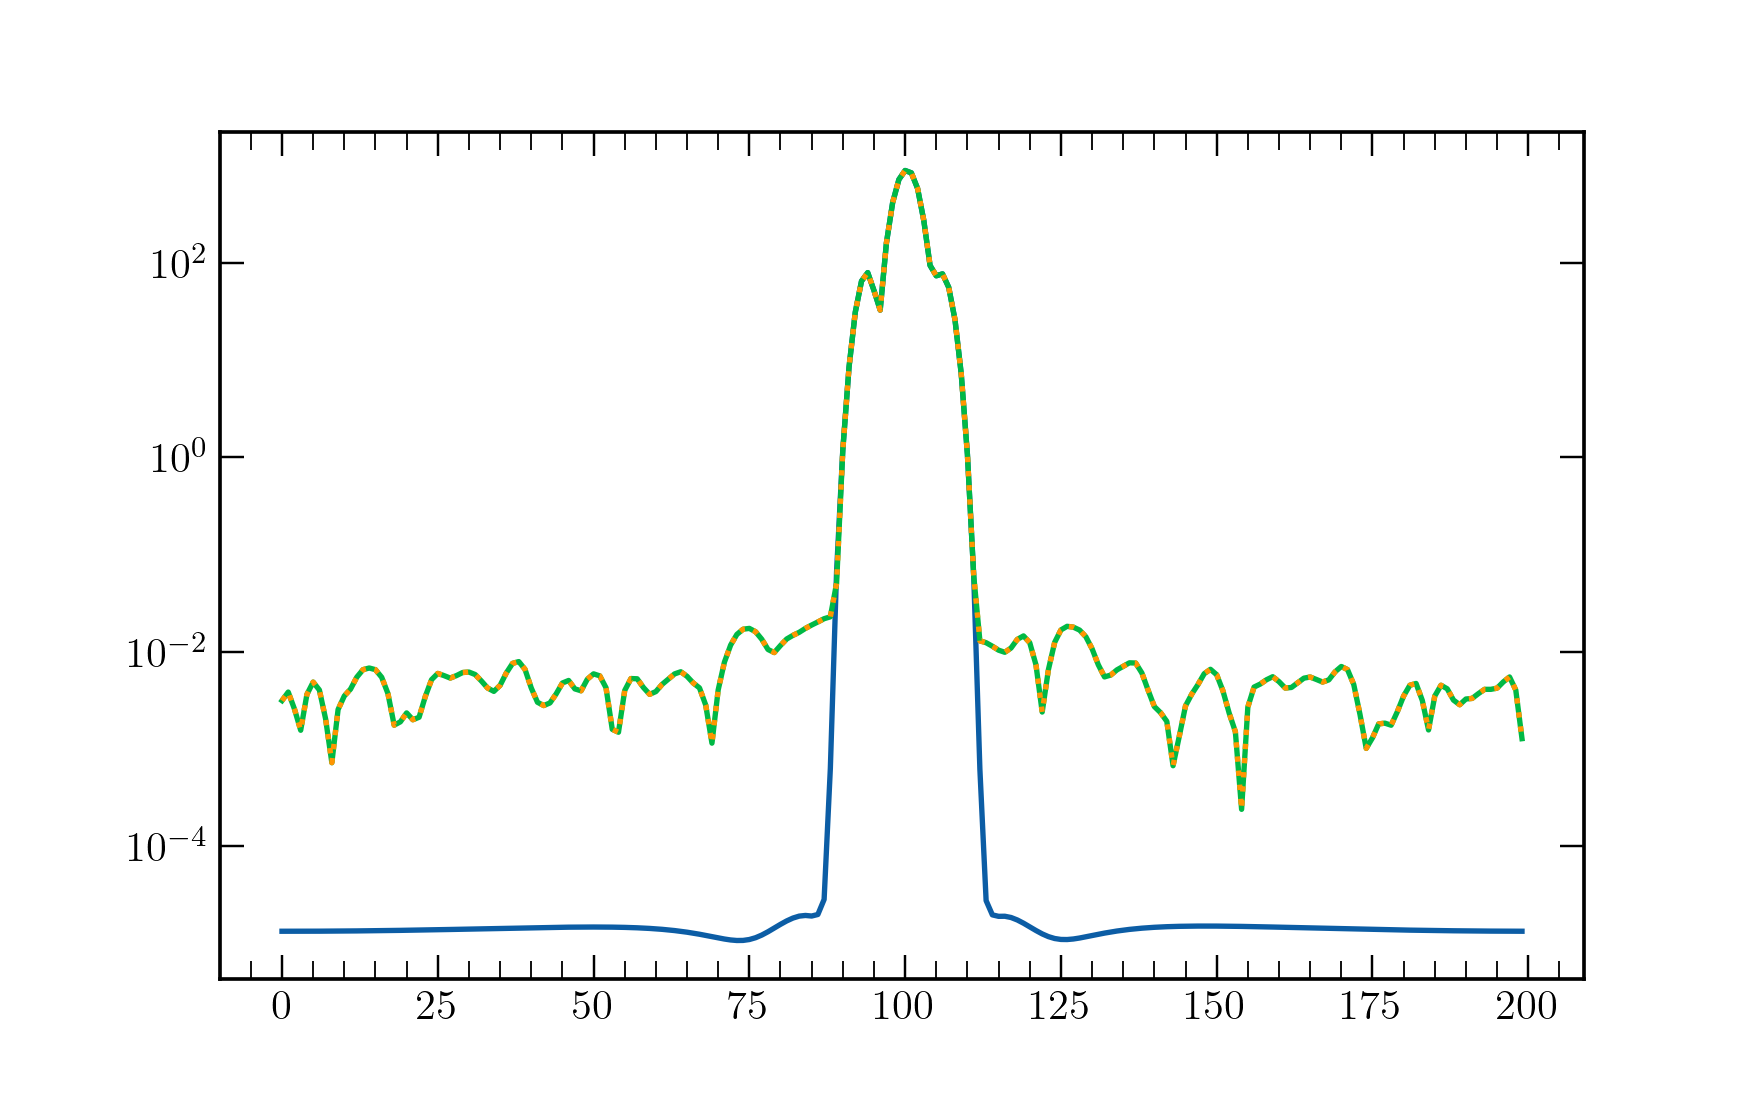

In [181]:
plt.figure()
plt.semilogy(delay_spectra(model_matrix[0, 1]))
plt.semilogy(delay_spectra(cal[0, 1]))
plt.semilogy(delay_spectra(cal_f[0, 1]), ls=':')
plt.show()

<IPython.core.display.Javascript object>


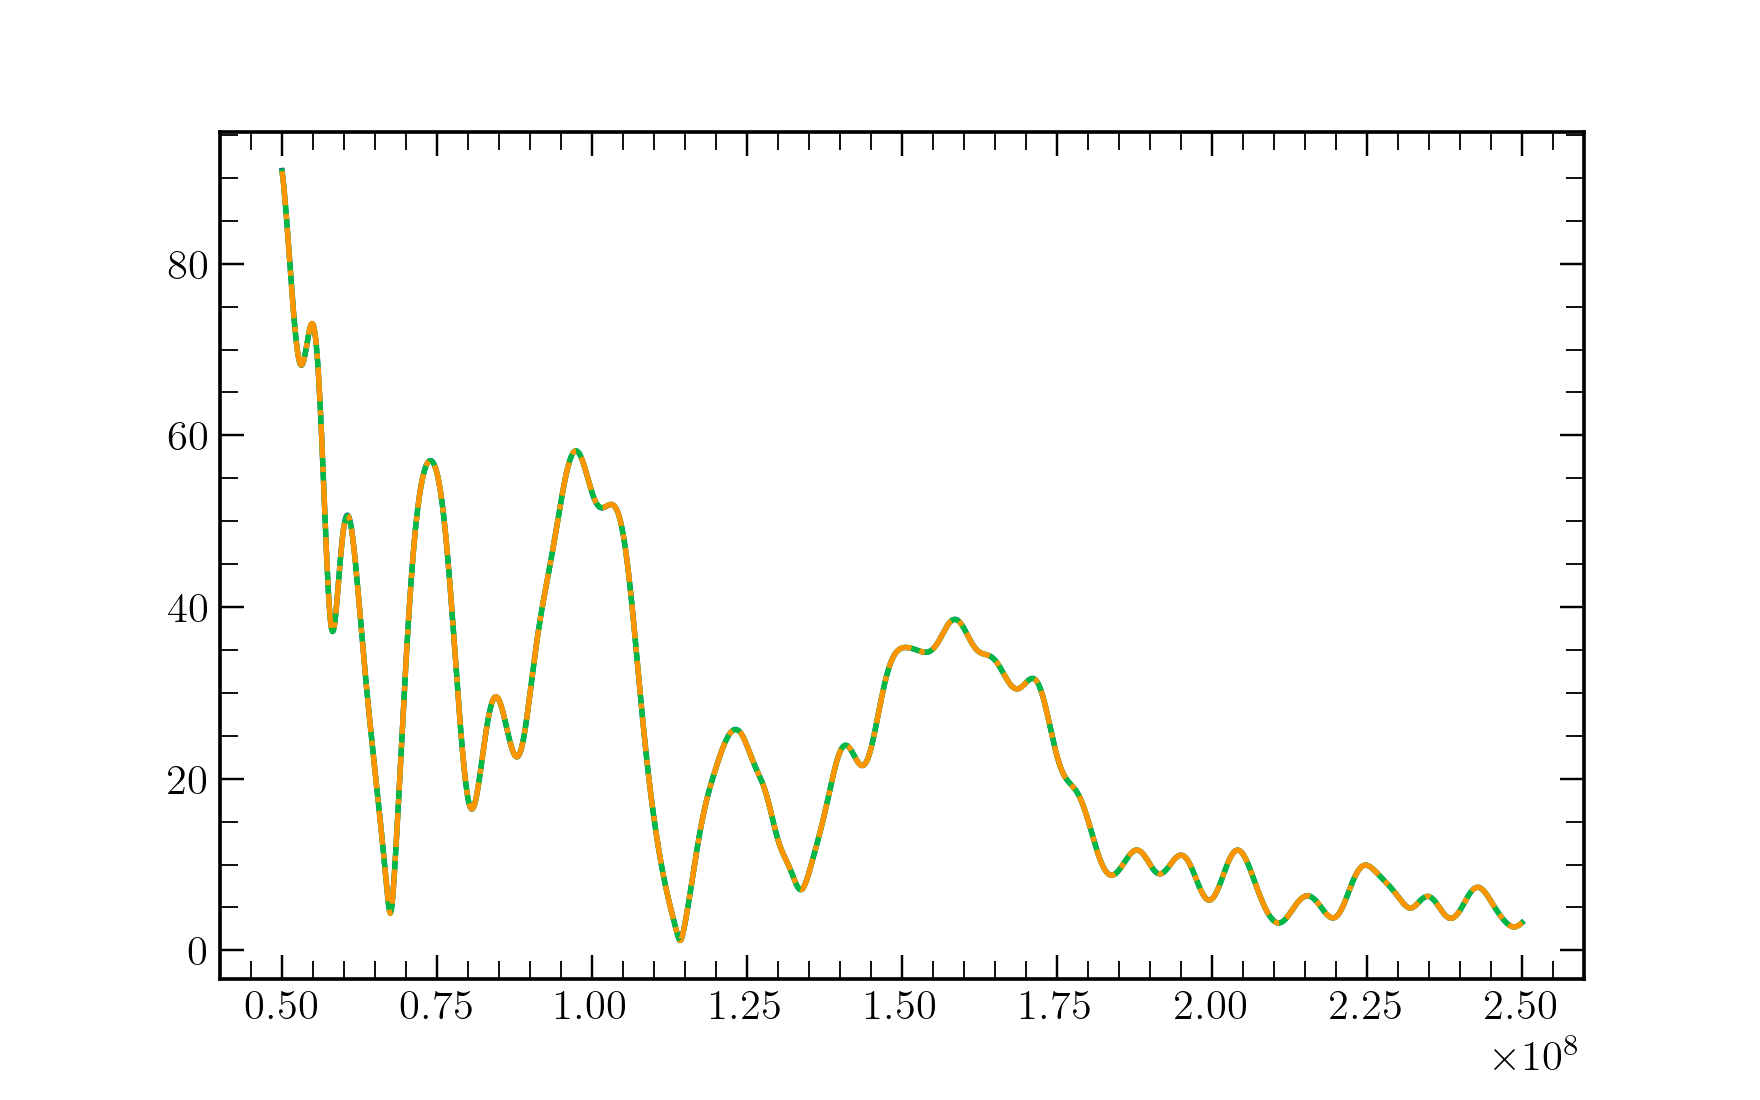

In [111]:
ant1, ant2 = 0, 9

plt.figure()
plt.plot(freqs, np.abs(model_matrix[ant1, ant2]))
plt.plot(freqs, np.abs(true_model_matrix[ant1, ant2]))
plt.plot(freqs, np.abs(cal_f[ant1, ant2]), ls='-.')
plt.show()

<IPython.core.display.Javascript object>


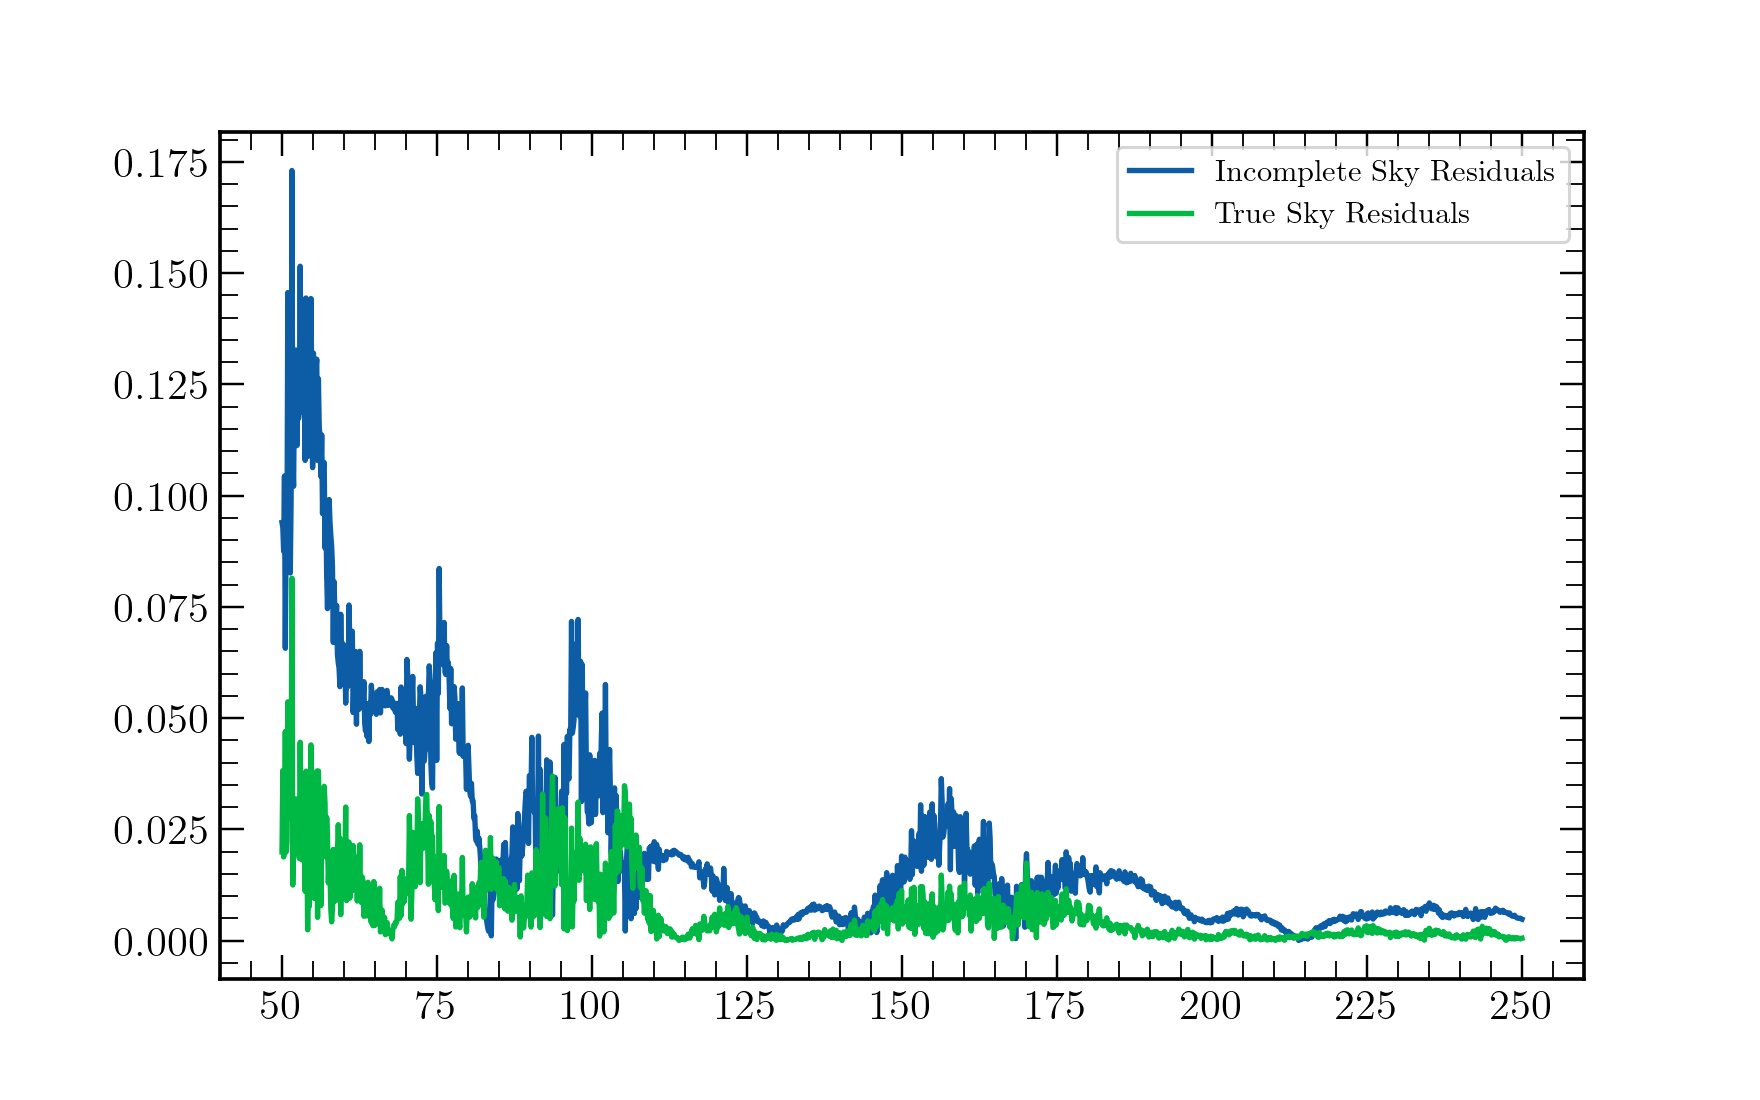

In [112]:
ant1, ant2 = 0, 9

plt.figure()
plt.plot(freqs / 1e6, np.abs(cal_f[ant1, ant2] - model_matrix[ant1, ant2]), label='Incomplete Sky Residuals')
plt.plot(freqs / 1e6, np.abs(cal_f[ant1, ant2] - true_model_matrix[ant1, ant2]), label='True Sky Residuals')
plt.legend()
plt.show()

## Fit Nucal Model to Calibrated Data

In [113]:
from hera_cal import nucal, datacontainer, apply_cal

In [117]:
gains = {(i, "Jnn"): gstef[i][None, :] for i in range(gstef.shape[0])}
dc = datacontainer.DataContainer({k + ('nn', ): np.copy(vis_dict[k])[None, :] for k in vis_dict})
wgts = {k: np.ones_like(dc[k]).real for k in dc}
apply_cal.calibrate_in_place(dc, gains)

In [120]:
radial_reds = nucal.RadialRedundancy(antpos)
spatial_filters = nucal.compute_spatial_filters(radial_reds, freqs)
spectral_filters = nucal.compute_spectral_filters(freqs, 20e-9)[0].real
nucal_model = nucal.fit_nucal_foreground_model(dc, wgts, radial_reds, spatial_filters, spectral_filters, tol=1e-9)

<IPython.core.display.Javascript object>


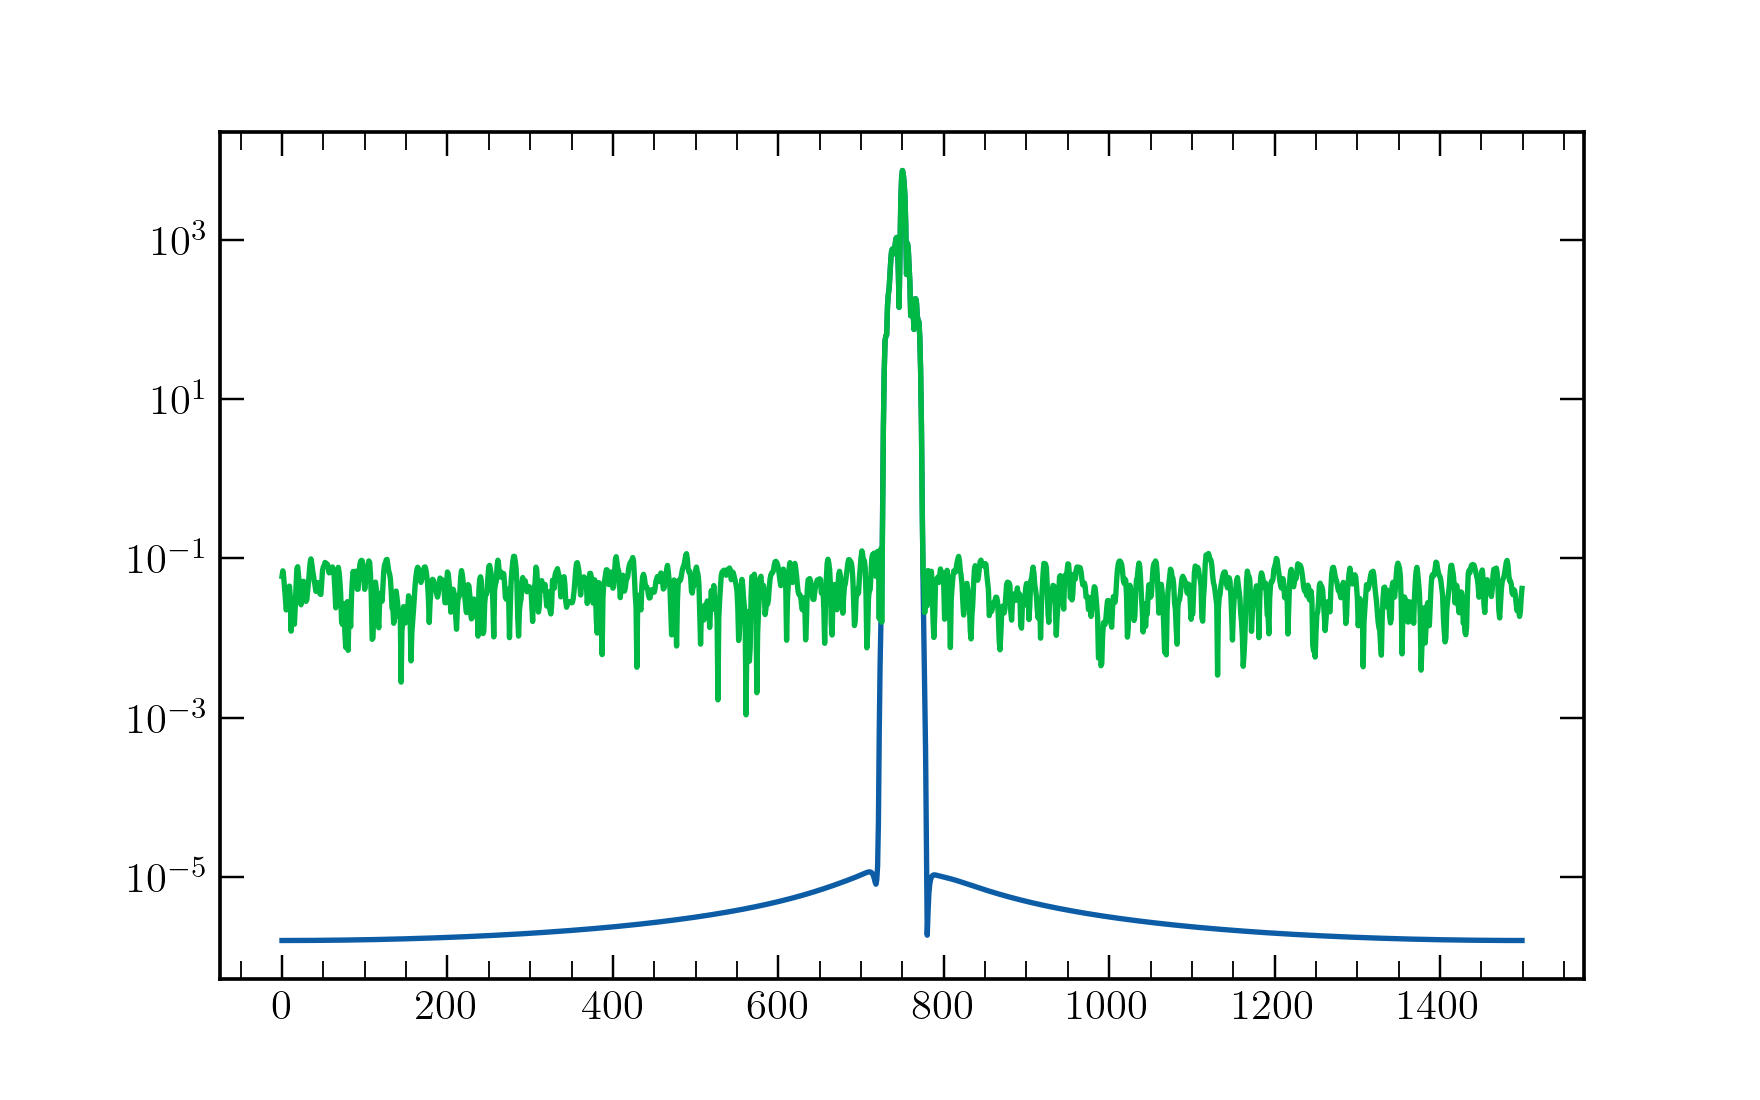

In [128]:
plt.figure()
plt.semilogy(delay_spectra(nucal_model[(0, 5, 'nn')][0]))
plt.semilogy(delay_spectra(dc[(0, 5, 'nn')][0]))

In [163]:
%%time
Nants = nants
fi = 0

data_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)
true_model_matrix = np.zeros((nants, nants, nfreqs), dtype=complex)

nucal_model = datacontainer.DataContainer(nucal_model)

for n in range(Nants):
    for m in range(Nants):
        if n != m:
            data_matrix[m, n] = vis_dict[(m, n)]
            model_matrix[m, n] = nucal_model[radial_reds.get_redundant_group((m, n, 'nn'))[0]][0]
            
wgts = np.ones_like(model_matrix).real

CPU times: user 216 ms, sys: 12.4 ms, total: 228 ms
Wall time: 242 ms


In [164]:
%%time
gstef_new, niter = run_stefcal(data_matrix, model_matrix, wgts, maxiter=1000, tol=1e-10, stepsize=0.5)

CPU times: user 233 ms, sys: 5.99 ms, total: 239 ms
Wall time: 238 ms


In [165]:
Gfn = gstef_new[:, None, :] * gstef_new[None, ...].conj()
cal_fn = data_matrix / Gfn

<IPython.core.display.Javascript object>


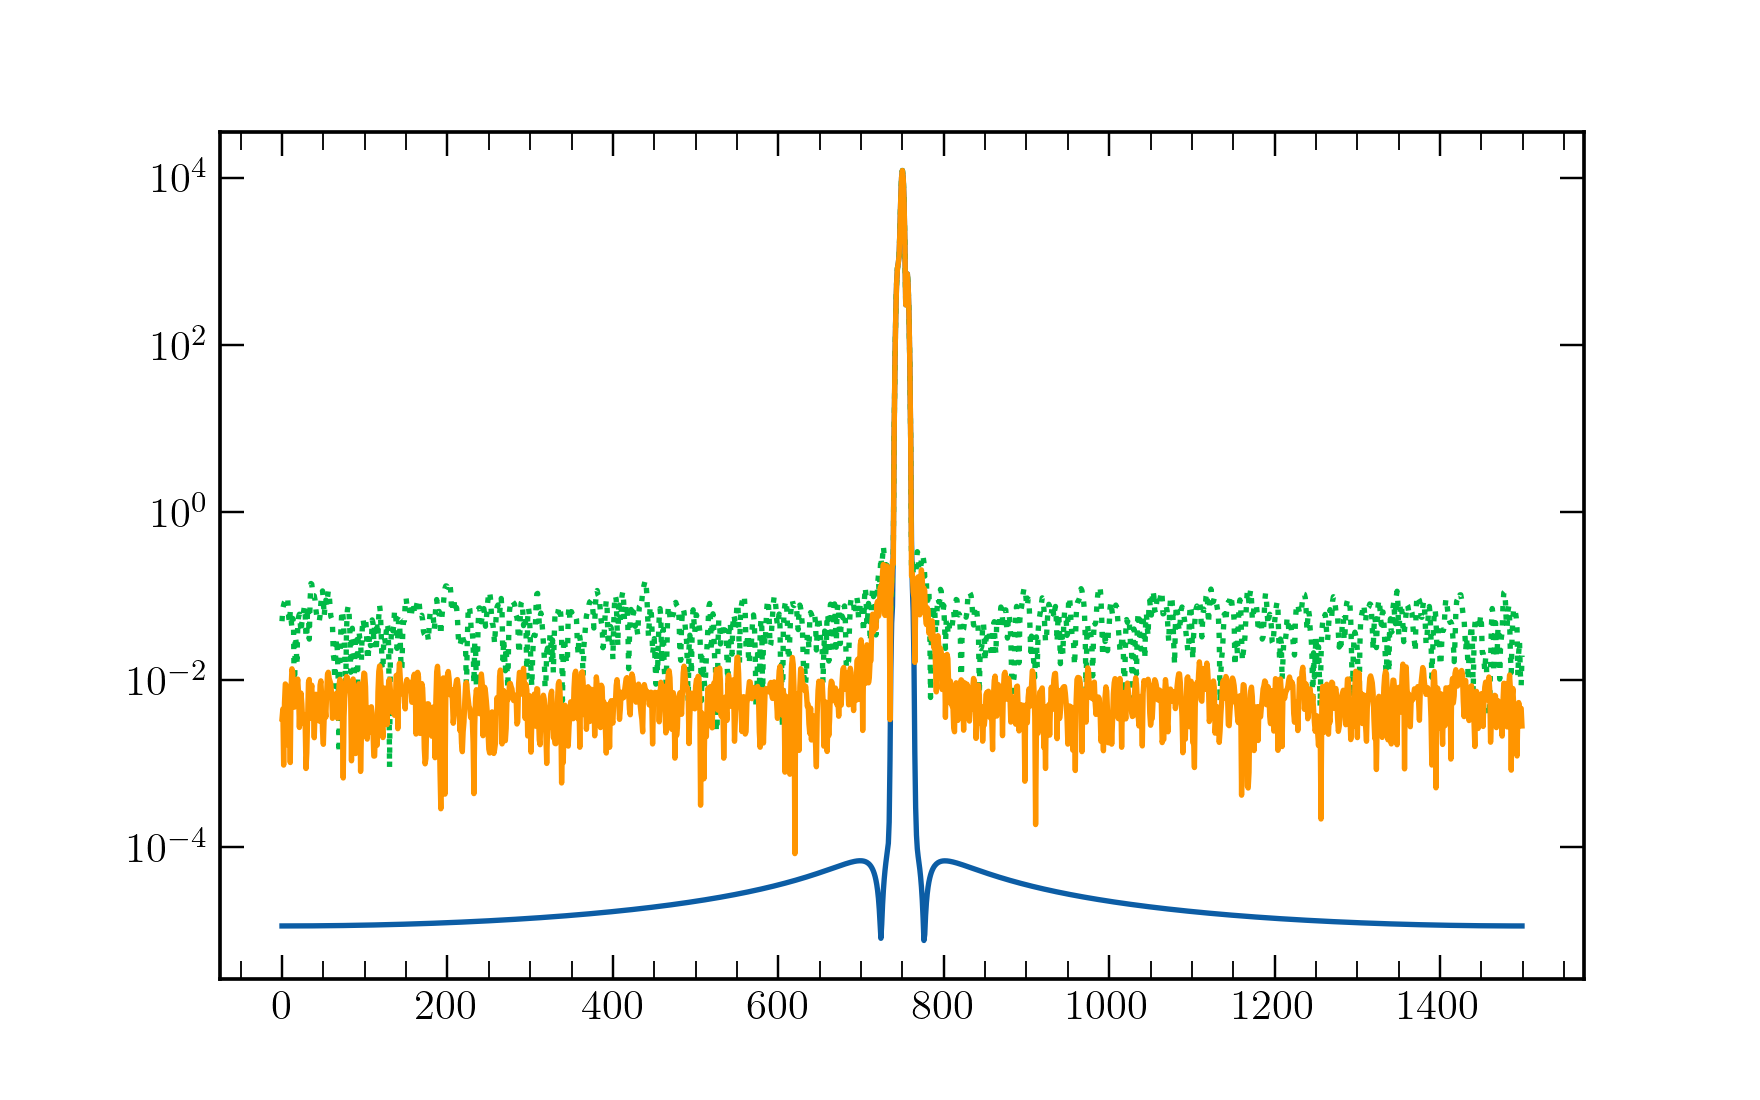

In [166]:
plt.figure()
plt.semilogy(delay_spectra(model_matrix[0, 1]))
plt.semilogy(delay_spectra(cal_f[0, 1]), ls=':')
plt.semilogy(delay_spectra(cal_fn[0, 1]))
plt.show()